# This notebook demos varios differential operators

We start with some imports & a small helper function to convert our stencil to SIR:

In [1]:
from typing import Callable

from inspect import getsource
import ast

from dusk.grammar import Grammar

from dawn4py import compile, CodeGenBackend
from dawn4py.serialization import make_sir, SIR
from dawn4py.serialization.SIR import GridType
from dawn4py._dawn4py import run_optimizer_sir

from typing import List


def dusk_to_sir(stencils: List[Callable]) -> SIR:
    # this will give wrong line numbers, there should be a way to fix them
    sir_stencils = []
    for stencil in stencils:
        stencil = ast.parse(getsource(stencil))
        assert isinstance(stencil, ast.Module)
        assert len(stencil.body) == 1
        stencil = stencil.body[0]
        assert Grammar.is_stencil(stencil)
        sir_stencils.append(Grammar().stencil(stencil))
    return make_sir(
        "notebook stencils", GridType.Value("Unstructured"), sir_stencils
    )

With the above definitions, we can write our differential operators

In [2]:
from dusk.script import *


@stencil
def gradient(f: Field[Edge], nx: Field[Edge], ny: Field[Edge], L: Field[Edge], A: Field[Cell], edge_orientation: Field[Cell > Edge], 
                f_x: Field[Cell], f_y: Field[Cell]):
  with levels_downward:
    f_x = sum_over(Cell > Edge, f * nx * L * edge_orientation) / A
    f_y = sum_over(Cell > Edge, f * ny * L * edge_orientation) / A

@stencil
def divergence(u: Field[Edge], v: Field[Edge], nx: Field[Edge], ny: Field[Edge], L: Field[Edge], A: Field[Cell], edge_orientation: Field[Cell > Edge],
                  uv_div: Field[Cell]):
  with levels_downward:
    uv_div = sum_over(Cell > Edge, (u*nx + v*ny) * L * edge_orientation) / A

@stencil
def curl(u: Field[Edge], v: Field[Edge], nx: Field[Edge], ny: Field[Edge], dualL: Field[Edge], dualA: Field[Vertex], edge_orientation: Field[Vertex > Edge],
            uv_curl: Field[Vertex]):
  with levels_downward:
    uv_curl = sum_over(Vertex > Edge, (u*nx + v*ny) * dualL * edge_orientation) / dualA 

Then we can use dusk to convert the stencils to SIR. With dawn we can compile SIR to C++.

In [3]:
sir = dusk_to_sir([gradient, divergence, curl])
cpp_naive = compile(sir, backend=CodeGenBackend.CXXNaiveIco)
with open("diff_ops_cxx-naive.cpp", "w+") as f:
    f.write(cpp_naive)

The generated C++ code also requires a driver which is already setup for this demo. With the driver code we can generate an executable `runner`:

In [17]:
!make

Now, its up to you which differentail operator you want to run and check. Simply launch `runner gradient`, `runner divergence` or `runner curl`

In [18]:
!./runner curl

mesh stats: #cells 1760 #nodes 940 #edges 2699
curl_uv L1: 0.001434, L2: 0.001863, Linf: 0.004384


Besides ensuring the error norms L1, L2 and L infinity are small (they should all be well below 0.1), you can also have a look at some test functions and their differentials. Again, you can use `check gradient`, `check divergence` or `check curl`. Please make sure that you ran the appropriate differential operator beforhand using the `runner`

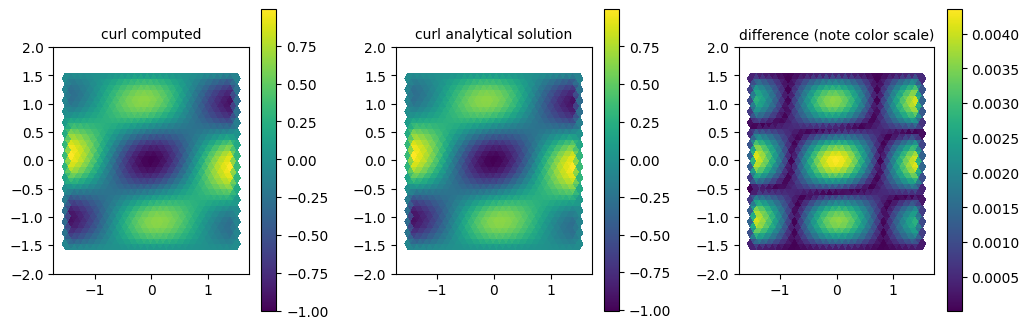

In [23]:
%run checker.py curl